<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/CNN_2_class_PyTorch_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Общие настройки
*  импорт библиотек
*  функция обучения
*  функция оценки модели
*  функции отрисовки графиков (2 шт)
*  засекание времени





####Импорт необходимых библиотек

In [1]:
import torch
from torch import nn

#  Импорт библиотек для загрузки данных
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


#  Импорт библиотек для отрисовки графиков



#  Импорт библиотеки для вывода полосы прогресса

#  Импорт библиотеки для таймера

import matplotlib.pyplot as plt
from PIL import Image
import random #  для вывода случайных изображений

import numpy as np

import requests
import zipfile
from pathlib import Path
import os

from typing import Tuple, Dict, List

####Функция по обучению модели

####Функция по оценке модели модели

####Функции вывода графиков с изображениями

In [2]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
  """
    Строит набор из n графиков изображений, расположенных в папке image_path и
    обработанных преобразованием transforms
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Оригинальный \nРазмер: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0) 
      ax[1].imshow(transformed_image) 
      ax[1].set_title(f"Преобразованный \nРазмер: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Метка: {image_path.parent.stem}")

In [3]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

####Функции вывода графиков с результатами обучения

####Функция засекания времени работы модели (function model execution time)

####Установка устройства `"cuda"`

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"

####Загрузка датасета

In [5]:
# подключение гугл диска, на котором хранится zip-архив с датасетом
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
#  Установить пути к папке с данными. 
image_path = Path('/content/WineYardDataset')

if image_path.is_dir():
  print(f"{image_path} папка для распаковки датасета существует")
else:
  print(f"{image_path} не существует, создана новая папка ...")
  image_path.mkdir(parents = True, exist_ok = True)

  #  здесь могла бы быть загрузка файла, но файл итак на гугл диске, поэтому
  #  можно дописать в случае необходимости и библиотеки request

  #  Распаковка архива
  with zipfile.ZipFile("/content/drive/MyDrive/Виноградники/Dataset.zip", "r") as zip_ref:
    print("Распаковка...")
    zip_ref.extractall(image_path)




/content/WineYardDataset не существует, создана новая папка ...
Распаковка...


In [7]:
image_path = Path('/content/WineYardDataset/Dataset')

In [8]:
##  Другой способ распаковать архив. Проще. Быстрее. Понятнее
##  !unzip /content/drive/MyDrive/Виноградники/Dataset.zip

In [9]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/WineYardDataset/Dataset'.
There are 2 directories and 0 images in '/content/WineYardDataset/Dataset/train'.
There are 0 directories and 8484 images in '/content/WineYardDataset/Dataset/train/1'.
There are 0 directories and 3085 images in '/content/WineYardDataset/Dataset/train/2'.
There are 2 directories and 0 images in '/content/WineYardDataset/Dataset/test'.
There are 0 directories and 1212 images in '/content/WineYardDataset/Dataset/test/1'.
There are 0 directories and 442 images in '/content/WineYardDataset/Dataset/test/2'.
There are 2 directories and 0 images in '/content/WineYardDataset/Dataset/val'.
There are 0 directories and 2424 images in '/content/WineYardDataset/Dataset/val/1'.
There are 0 directories and 881 images in '/content/WineYardDataset/Dataset/val/2'.


Дальше посмотрим на структуру данных и не будем торопиться. 
Во-первых, выведем на экран случайное изображение

Random image path: /content/WineYardDataset/Dataset/train/1/frame_8877.jpg
Image class: 1
Image height: 360
Image width: 360


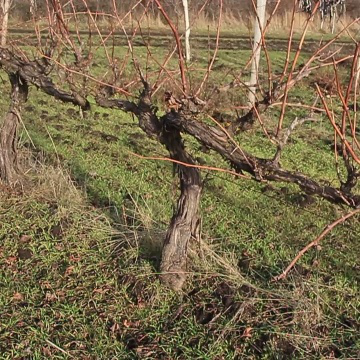

In [10]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
# 3. Получите класс изображения по имени пути (класс изображения - это имя каталога, в котором хранится изображение)
image_class = random_image_path.parent.stem
image = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")
image

**ИЛИ** тоже самое с помощью 

```
 matplotlib.pyplot.imshow()
```
но сначала переведем в массив `numpy`.
Предпочтительнее matplotlib


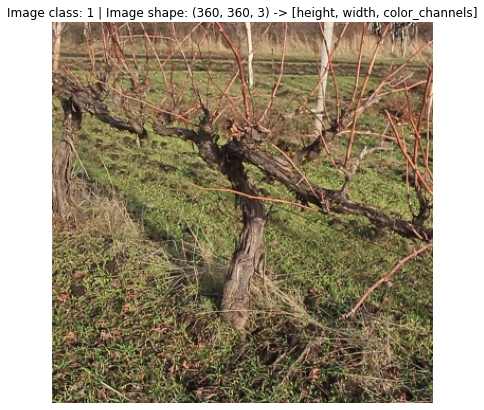

In [11]:
image_as_array = np.array(image)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

###Первая модель
*Описание модели*

####Трансформация данных
Не забыть про аугментацию (augmentation)


[Смотреть здесь](https://www.learnpytorch.io/04_pytorch_custom_datasets/#3.-Transforming-data)

In [12]:
data_transformation = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() #обращает значения пикселей от 0 до 255 в значения от 0.0 до 1.0
])

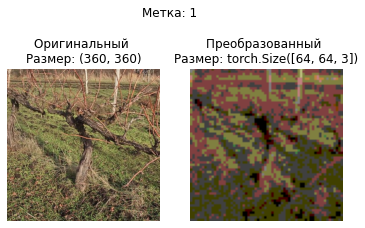

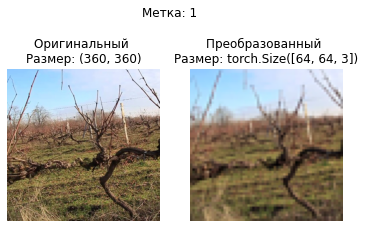

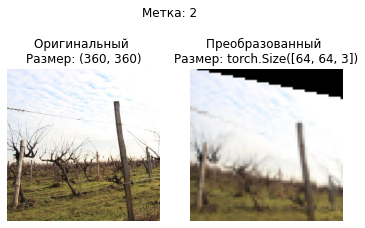

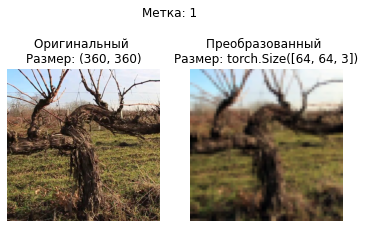

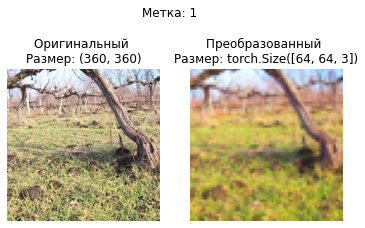

In [13]:
plot_transformed_images(image_paths=image_path_list,
                        transform = data_transformation,
                        n = 5)

####Загрузка датасета в DataLoader

In [14]:
train_dir = image_path / "train"
test_dir = image_path / "test"


In [15]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transformation,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transformation)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 11569
    Root location: /content/WineYardDataset/Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1654
    Root location: /content/WineYardDataset/Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


In [16]:
class_names = train_data.classes
class_names
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'1': 0, '2': 1}

In [17]:
len(train_data), len(test_data)

(11569, 1654)

Оригинальная форма: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Трансформированная форма: torch.Size([64, 64, 3]) -> [height, width, color_channels]


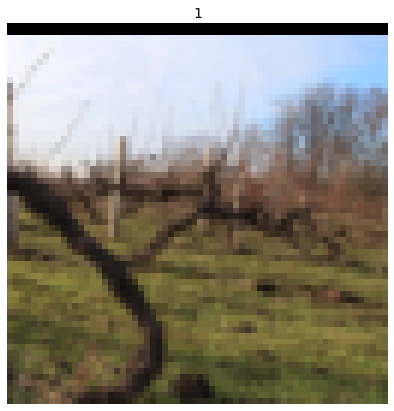

In [18]:
#  Первое изображение в датасете
image, label = train_data[0][0], train_data[0][1]
#  CHW -> HWC
img_permute = image.permute(1, 2, 0)


print(f"Оригинальная форма: {image.shape} -> [color_channels, height, width]")
print(f"Трансформированная форма: {img_permute.shape} -> [height, width, color_channels]")

#  Вывод изображения
plt.figure(figsize=(10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [19]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # как много кадров в батче
                              num_workers=NUM_WORKERS, # как много процессов использовать для работы
                              shuffle=True) # перемешать данные

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data
print(f"Создание DataLoaders с batch: {BATCH_SIZE} и workers: {NUM_WORKERS}.")
train_dataloader, test_dataloader

Создание DataLoaders с batch: 32 и workers: 2.


(<torch.utils.data.dataloader.DataLoader at 0x7fe055b0c4c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe055b0c520>)

In [20]:
img, label = next(iter(train_dataloader))

# Batch size - это первое число
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


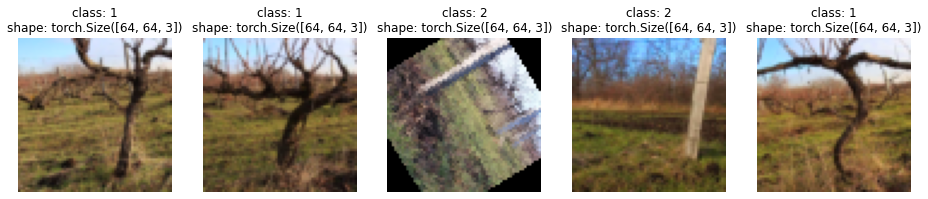

In [21]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


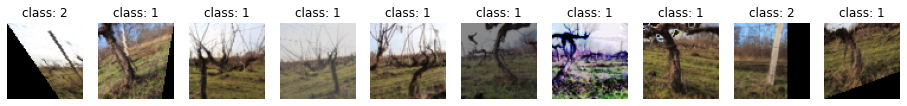

In [22]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

####Описание слоев модели и инициализация модели
Начать с TINY

In [23]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

Проверка модели

In [ ]:
#Сначала вытащим один батч
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label.batch[0]


####Назначение оптимизатора (optimizer) и функции потерь (loss_fn)

####Цикл обучения

####Тестирование

####Вывод графика обучения

####Вывод тестовых данных (изображение и метка)
image, label 

###Сравнение результатов моделей

####Подбор гиперпараметров (hyperparameter tuna)

Официальный туториал [здесь](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)


In [44]:
form = input()
genre = input()
year = int(input())
if form == 'фильм':
    if genre == 'комедия':
        if year == 2010:
           ....
        elif year == 1990:
            
        else:
            print('Я знаю только картины с годами выпуска от 1990 до 2019')
    elif genre == 'драма':
        
    ....
    else:
        print('Доступные жанры: комедия, драма, фантастика, мультфильм, приключения')
else:
    if genre == 'комедия':
        if year == 2010:
           ....
        elif year == 1990:
            
        else:
            print('Я знаю только картины с годами выпуска от 1990 до 2019')
    elif genre == 'драма':
       ....
    elif genre == 'приключения':
        if year == 2010:
            print('Гравити Фолз')
        elif
        ...
    else:
        print('Доступные жанры: комедия, драма, фантастика, мультфильм, приключения')

SyntaxError: ignored